In [1]:
from pathlib import Path
from definitions import ROOT_DIR
import pandas as pd
import numpy as np
from itertools import product
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':16})
rc('pdf', fonttype=42)
rc('ps', fonttype=42)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [11]:
def get_class_size(metadata, class_column):
    sizes = metadata[class_column].value_counts()
    metadata['class_size'] = [sizes[k] for k in metadata[class_column]]
    return metadata


def filter_neutral_losses(df, neutral_losses=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    If neutral_loss value us "only_nl", than consider only ions that have neutral losses
    '''
    
    if neutral_losses == "only_nl":
        df = df[df.neutral_loss != ""]
    elif neutral_losses != None:
        df = df[df.neutral_loss.isin(neutral_losses)]
    return df


def filter_adducts(df, adducts=['']):
    '''
    Filter out entries for ions with adducts that are not in the list provided
    '''
    if adducts != None:
        df = df[df.adduct.isin(adducts)]
    return df


def filter_polarity(df, polarity=None):
    '''
    Filter out entries based on polarity pol ['positive', 'negative']
    '''
    if polarity != None:
        df = df[df.Polarity == polarity]
    return df


def filter_data(data, polarity=None, adducts=None, neutral_losses=None):
    '''
    Apply polarity, adduct and neutral_loss filters
    '''
    data = filter_polarity(data, polarity)
    data = filter_adducts(data, adducts)
    data = filter_neutral_losses(data, neutral_losses)
    
    return data


def group_by_molecule(df, groupby_columns):
    '''
    Aggregate intensity and detection values per groupby columns
    '''          
    data = df.groupby(groupby_columns).agg(
        {'detectability' : 'max'}).reset_index()
    return data


def summarise_per_class(df, groupby_columns):
    
    data = df.pivot_table(index=groupby_columns,
                      values=['detectability', 'class_size'],
                      aggfunc = {
                                'class_size':'first',
                                'detectability':'sum'
                                }).reset_index()

    data['fraction_detected'] = data.detectability / data.class_size 
    data.drop(columns=['detectability', 'class_size'], inplace=True)
    
    return data


def zero_fill_data(df, classification, class_col_name):
    
    missing_columns = set(classification[class_col_name]) - set(df[class_col_name])
    
    data = df.pivot_table(index=['origin', 'dataset_id'],
                           columns=class_col_name,
                           values='fraction_detected', 
                           fill_value=0)
    
    if len(missing_columns) > 0:
        data[list(missing_columns)] = 0
        
    data = data.melt(ignore_index=False)
    
    return data


def make_a_plot(plot_data, title, figsize=(5, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    g = sns.scatterplot(data=plot_data, 
                        x='spots', 
                        y='tissue', 
                        color='k', 
                        alpha=0.7,
                        linewidth=0,
                        ax=ax,
                        s=100)
    sns.lineplot(x=[0,1], y=[0,1], color='grey', ax=ax)
    g.set(title = title,
          ylabel='In mammalian tissues',
          xlabel='In the standard samples')
    
    return g

def colour_a_plot(plot_data, title, figsize=(5, 5)):
    
    palette = { #Paul Tol palette for colour blindness
     "Amines":'#DDCC77', #yellow
     "Amino acids, peptides, and analogues":'#332288', #blue
     "Carbohydrates":'#117733', #green
     "Carboxylic acids":'#44AA99', #emerald
     "Lipids and lipid-like molecules":'#AA4499', #magenta
     "Nucleosides, nucleotides, and analogues":'#CC6677', #light red
     "Vitamins and cofactors":'#88CCEE', #lightblue
    }
    
    fig, ax = plt.subplots(figsize=figsize)
    g = sns.scatterplot(data=plot_data, 
                        x='spots', 
                        y='tissue', 
                        hue='main_coarse_class',
                        palette=palette,
                        alpha=1,
                        edgecolor='k',
                        linewidth=0.2,
                        ax=ax,
                        s=100)
    sns.lineplot(x=[0,1], y=[0,1], color='grey', ax=ax)
    g.set(title = title,
          ylabel='In mammalian tissues',
          xlabel='In the standard samples')
    g.legend(bbox_to_anchor=(1,1), frameon=False)
    
    return g


def annotate_plot(plot_data, title):
    # add annotations one by one with a loop
    annotated_p = make_a_plot(plot_data, title, figsize=(15,15))
    for line in range(0,plot_data.shape[0]):
         plt.text(plot_data.spots[line]+0.01, 
                  plot_data.tissue[line], 
                  plot_data.index[line], 
                  horizontalalignment='left', 
                  size='medium', 
                  color='black',)

    return annotated_p

# This notebook aims to compare detectability of metabolites in spotting project and a selection of biological tissues

In [3]:
p_root_dir = Path(ROOT_DIR).parent
p_data = p_root_dir / "5_data_analysis"
p_analysis = p_root_dir / "6_plots/spotting_vs_metaspace"
p_out = p_analysis / "plots"

# Predicitons for metabolite detectability for all ions in their target wells in spotted samples
p_predictions = p_data / "all_predictions_curated_11-Dec-2021.csv"

# Spotted dataset metadata
p_datasets = p_data / "Datasets_14Jul2022.csv"

# Tissue dataset metadata
p_tissue_metadata = p_analysis / r"tissue_metadata.csv"

# # Mapping on formulas to metabolite names
p_name_map = p_data / "wellmap.csv"

# Classification
p_chem_class = p_data / "custom_classification_v2.csv"

In [4]:
# Load predictions, format neutral loss column
# Note that only best matrix replicate is used from the spotting project
predictions = pd.read_csv(p_predictions, index_col=0)[['dataset_id', 
                                                'name_short', 
                                                'formula',
                                                'adduct', 
                                                'neutral_loss', 
                                                'pred_val']]
predictions.neutral_loss.fillna("", inplace=True)

# Add dataset metadata 
datasets = pd.read_csv(p_datasets)
datasets_info = datasets.groupby('Dataset ID').first()[['Polarity', 'Matrix short', 'EMBL']]
df = pd.merge(predictions, datasets_info, left_on='dataset_id', right_on='Dataset ID', how='left')

# Only consider data of detected ions
threshold=0.8
df['detectability'] = df.pred_val >= threshold
df = df[df.detectability].drop(columns='pred_val')

# Filter data to include only DHB+ and DAN-
df['origin'] = 'spots'
spots_dhb = df[(df['Matrix short'] == 'DHB') & (df['Polarity'] == 'positive')].drop(columns=['Polarity', 'Matrix short', 'EMBL'])
spots_dan = df[(df['Matrix short'] == 'DAN') & (df['Polarity'] == 'negative')].drop(columns=['Polarity', 'Matrix short', 'EMBL'])

In [5]:
p_manual_labels = p_analysis / "manually_labelled_images"

In [6]:
labelled_set = []

for img in (p_manual_labels / "pass").rglob("*.png"):
    filename = img.stem

    labelled_set.append({
        'dataset_id':img.stem[0:20],
        'formula':img.stem.split('_')[2],
        'adduct':img.stem.split('_')[3],
        'neutral_loss':'',
        'detectability':True
    })
        
manual_tissue_df = pd.DataFrame(labelled_set)

In [7]:
tissue_metadata = pd.read_csv(p_tissue_metadata)
name_map = pd.read_csv(p_name_map)[['formula', 'name_short']]

manual_tissue_df = manual_tissue_df.merge(tissue_metadata[['dataset_id', 'matrix', 'polarity', 'dataset_name']], on='dataset_id', how='left').rename(columns={'dataset_id':'dataset_id'})
manual_tissue_df['origin'] = 'tissue'
manual_tissue_df = manual_tissue_df.merge(name_map, on='formula', how='left')

manual_tissue_dhb = manual_tissue_df[manual_tissue_df.matrix=='DHB'].drop(columns=['matrix', 'polarity', 'dataset_name'])
manual_tissue_dan = manual_tissue_df[manual_tissue_df.matrix=='DAN'].drop(columns=['matrix', 'polarity', 'dataset_name'])

In [8]:
# Combine spotting and tissue data in one datarame
manual_dhb = pd.concat([spots_dhb, manual_tissue_dhb])
manual_dan = pd.concat([spots_dan, manual_tissue_dan])

In [9]:
# Load classification, add class size info
classes = pd.read_csv(p_chem_class, index_col='internal_id')
chem_subclass = get_class_size(classes[['name_short', 'coarse_class', 'fine_class']],  # coarse class here is to sort rows in the plot
                              'fine_class')

- DHB

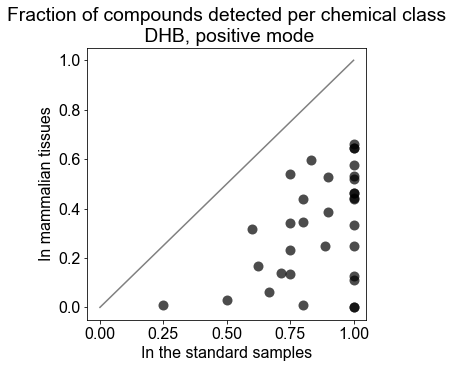

In [10]:
# Filter data
filtered_data = filter_data(manual_dhb, 
                            adducts=['+H', '+Na', '+K'],
                            neutral_losses=[""])

# Calculate detectability per metabolite and dataset
molecule_data = group_by_molecule(filtered_data, groupby_columns=['name_short', 'origin', 'dataset_id'])

# Map chemical class to the metabolite
mapped_data = molecule_data.merge(chem_subclass, on='name_short', how='left')

# Summarise data per class (mean of detected metabolites, and fraction of detected ions per class)
class_data = summarise_per_class(mapped_data, groupby_columns=['origin', 'dataset_id', 'fine_class'])

# Zero-fill the data
zero_filled_data = zero_fill_data(class_data, classification=chem_subclass, class_col_name='fine_class')

# Calculate mean detectability among all datasets
plot_data = zero_filled_data.pivot_table(index='fine_class',
                                         columns='origin',
                                         values='value',
                                         aggfunc='mean')
 
# Make a plot
make_a_plot(plot_data, title='Fraction of compounds detected per chemical class\n DHB, positive mode')
plt.savefig(p_out/ f"Detections_in_spots_vs_tissue_DHB_manual_labels.png")
plt.savefig(p_out/ f"Detections_in_spots_vs_tissue_DHB_manual_labels.pdf")

- Make the same plot but colour coding the dots by class

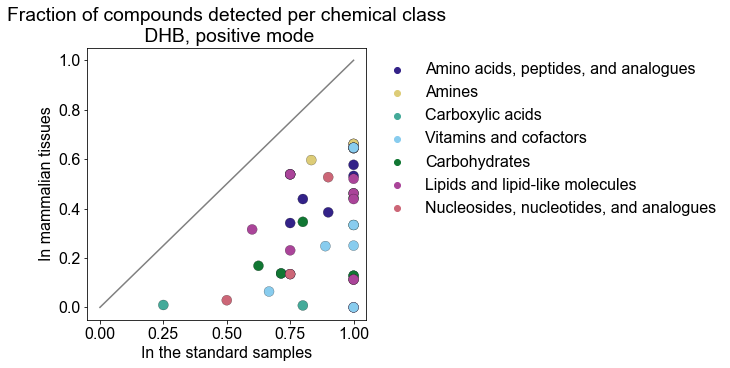

In [12]:
# Map class information, for some sub-classes there are multiple coarse classes, they will just overlap in the plot
class_map = classes[['main_coarse_class', 'fine_class']].drop_duplicates()
col_data = plot_data.merge(class_map, on='fine_class', how='left')

# Make a plot
colour_a_plot(col_data, title='Fraction of compounds detected per chemical class\n DHB, positive mode')
plt.savefig(p_out/ f"Detections_in_spots_vs_tissue_DHB_manual_labels_coloured.png")
plt.savefig(p_out/ f"Detections_in_spots_vs_tissue_DHB_manual_labels_coloured.pdf")

- Compute some stats

In [13]:
all_metabs = pd.DataFrame(index=classes.name_short.unique())

stats1 = []
stats2 = []
for ds in molecule_data.loc[molecule_data.origin == 'tissue', 'dataset_id'].unique():
    
    # Select spot data and tissue data for one ds at a time
    subset = molecule_data.loc[(molecule_data.origin == 'spots') |
                               (molecule_data.dataset_id == ds)]
    
    summary_detected = subset.pivot_table(index='name_short',
                        columns='origin',
                        values='detectability',
                        fill_value=0)
    
    summary_detected = summary_detected.merge(all_metabs, left_index=True, right_index=True, how='outer').fillna(0)
    
    n_deteceted_in_tissue = summary_detected.tissue.sum() # detected in tissue
    n_also_detected_in_spots = summary_detected.all(axis=1).sum()  # detected in both
    fraction1 = 100*n_also_detected_in_spots /  n_deteceted_in_tissue
    stats1.append(fraction1)
    
    n_not_detected_in_spots = (summary_detected.spots==0).sum() # not detected in spots
    n_but_detected_in_tissue = summary_detected.loc[summary_detected.spots==0, 'tissue'].sum() # not detected in spots but detected in tissue
    fraction2 = 100*n_but_detected_in_tissue / n_not_detected_in_spots
    stats2.append(fraction2)
    
stat1 = np.around(np.mean(stats1),1)
print(f"On average, in DHB+  {stat1}% of metabolites deteteted in tissue were also detected in reference sample")

stat2 = np.around(np.mean(stats2),1)
print(f"On average, in DHB+  {stat2}% of metabolites not deteteted in reference sample were detected in tissue")

On average, in DHB+  94.7% of metabolites deteteted in tissue were also detected in reference sample
On average, in DHB+  12.9% of metabolites not deteteted in reference sample were detected in tissue


In [ ]:
print(plot_data)

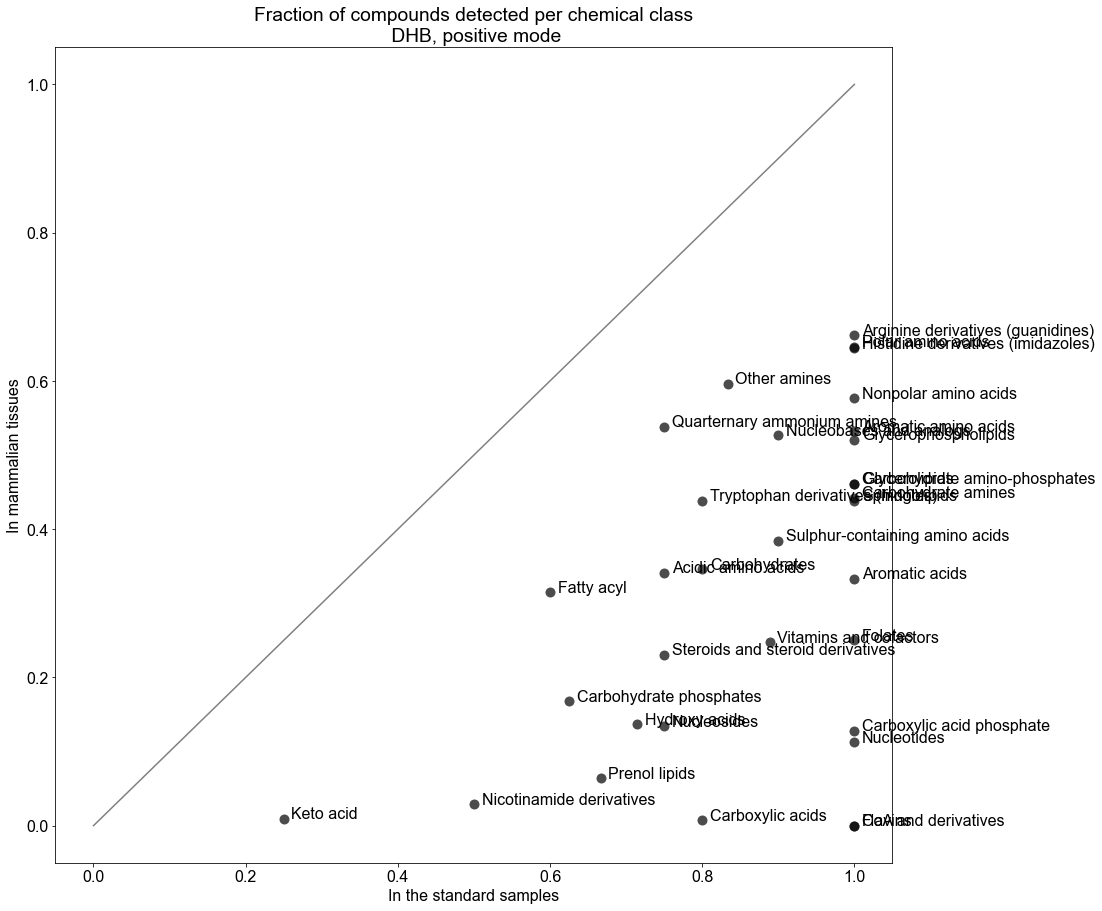

In [14]:
annotate_plot(plot_data, title='Fraction of compounds detected per chemical class\n DHB, positive mode')
plt.savefig(p_out/ f"Detections_in_spots_vs_tissue_DHB_manual_labels_annotated.png")
plt.savefig(p_out/ f"Detections_in_spots_vs_tissue_DHB_manual_labels_annotated.pdf")

- DAN

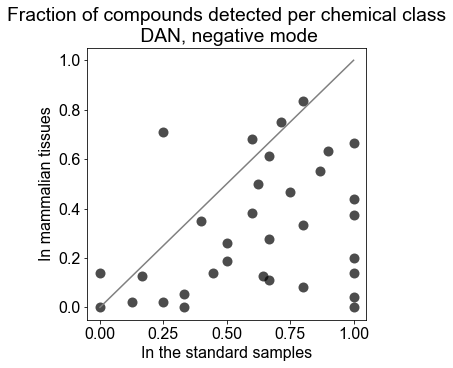

In [15]:
# Filter data
filtered_data = filter_data(manual_dan, 
                            adducts=['-H', '+Cl'],
                            neutral_losses=[""])

# Calculate detectability per metabolite and dataset
molecule_data = group_by_molecule(filtered_data, groupby_columns=['name_short', 'origin', 'dataset_id'])

# Map chemical class to the metabolite
mapped_data = molecule_data.merge(chem_subclass, on='name_short', how='left')

# Summarise data per class (mean of detected metabolites, and fraction of detected ions per class)
class_data = summarise_per_class(mapped_data, groupby_columns=['origin', 'dataset_id', 'fine_class'])

# Zero-fill the data
zero_filled_data = zero_fill_data(class_data, classification=chem_subclass, class_col_name='fine_class')

# Calculate mean detectability among all datasets
plot_data = zero_filled_data.pivot_table(index='fine_class',
                                         columns='origin',
                                         values='value',
                                         aggfunc='mean')
 
# Make a plot
make_a_plot(plot_data, title='Fraction of compounds detected per chemical class\n DAN, negative mode')
plt.savefig(p_out/ f"Detections_in_spots_vs_tissue_DAN_manual_labels.png")
plt.savefig(p_out/ f"Detections_in_spots_vs_tissue_DAN_manual_labels.pdf")

- Make the same plot but colour coding the dots by class

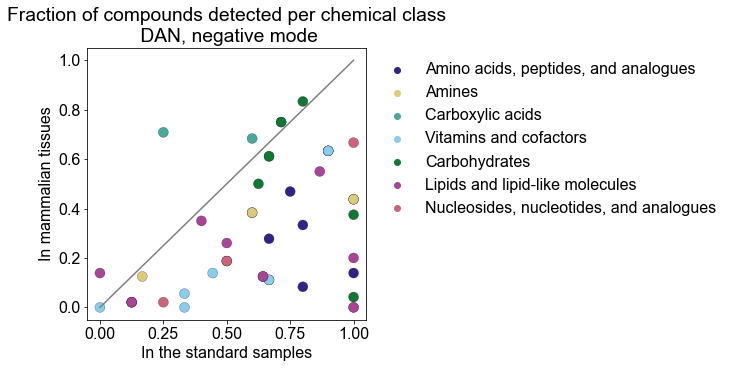

In [16]:
# Map class information, for some sub-classes there are multiple coarse classes, they will just overlap in the plot
class_map = classes[['main_coarse_class', 'fine_class']].drop_duplicates()
col_data = plot_data.merge(class_map, on='fine_class', how='left')

# Make a plot
colour_a_plot(col_data, title='Fraction of compounds detected per chemical class\n DAN, negative mode')
plt.savefig(p_out/ f"Detections_in_spots_vs_tissue_DAN_manual_labels_coloured.png")
plt.savefig(p_out/ f"Detections_in_spots_vs_tissue_DAN_manual_labels_coloured.pdf")

- Compute some stats

In [17]:
all_metabs = pd.DataFrame(index=classes.name_short.unique())

stats1 = []
stats2 = []
for ds in molecule_data.loc[molecule_data.origin == 'tissue', 'dataset_id'].unique():
    
    # Select spot data and tissue data for one ds at a time
    subset = molecule_data.loc[(molecule_data.origin == 'spots') |
                               (molecule_data.dataset_id == ds)]
    
    summary_detected = subset.pivot_table(index='name_short',
                        columns='origin',
                        values='detectability',
                        fill_value=0)
    
    summary_detected = summary_detected.merge(all_metabs, left_index=True, right_index=True, how='outer').fillna(0)
    
    n_deteceted_in_tissue = summary_detected.tissue.sum()
    n_also_detected_in_spots = summary_detected.all(axis=1).sum() # detected in tissue
    fraction1 = 100*n_also_detected_in_spots /  n_deteceted_in_tissue # detected in both
    stats1.append(fraction1)
    
    n_not_detected_in_spots = (summary_detected.spots==0).sum() # not detected in spots
    n_but_detected_in_tissue = summary_detected.loc[summary_detected.spots==0, 'tissue'].sum() # not detected in spots but detected in tissue
    fraction2 = 100*n_but_detected_in_tissue / n_not_detected_in_spots
    stats2.append(fraction2)
    
stat1 = np.around(np.mean(stats1),1)
print(f"On average, in DAN-  {stat1}% of metabolites deteteted in tissue were also detected in reference sample")

stat2 = np.around(np.mean(stats2),1)
print(f"On average, in DAN-  {stat2}% of metabolites not deteteted in reference sample were detected in tissue")

On average, in DAN-  78.2% of metabolites deteteted in tissue were also detected in reference sample
On average, in DAN-  24.3% of metabolites not deteteted in reference sample were detected in tissue


In [18]:
print(plot_data)

origin                                 spots    tissue
fine_class                                            
Acidic amino acids                  0.750000  0.468750
Arginine derivatives (guanidines)   0.600000  0.383333
Aromatic acids                      0.666667  0.111111
Aromatic amino acids                1.000000  0.138889
Carbohydrate amines                 1.000000  0.375000
Carbohydrate amino-phosphates       1.000000  0.041667
Carbohydrate phosphates             0.625000  0.500000
Carbohydrates                       0.800000  0.833333
Carboxylic acid phosphate           0.666667  0.611111
Carboxylic acids                    0.600000  0.683333
CoA and derivatives                 1.000000  0.000000
Fatty acyl                          0.400000  0.350000
Flavins                             0.333333  0.000000
Folates                             0.000000  0.000000
Glycerolipids                       0.000000  0.138889
Glycerophospholipids                0.866667  0.550000
Histidine 

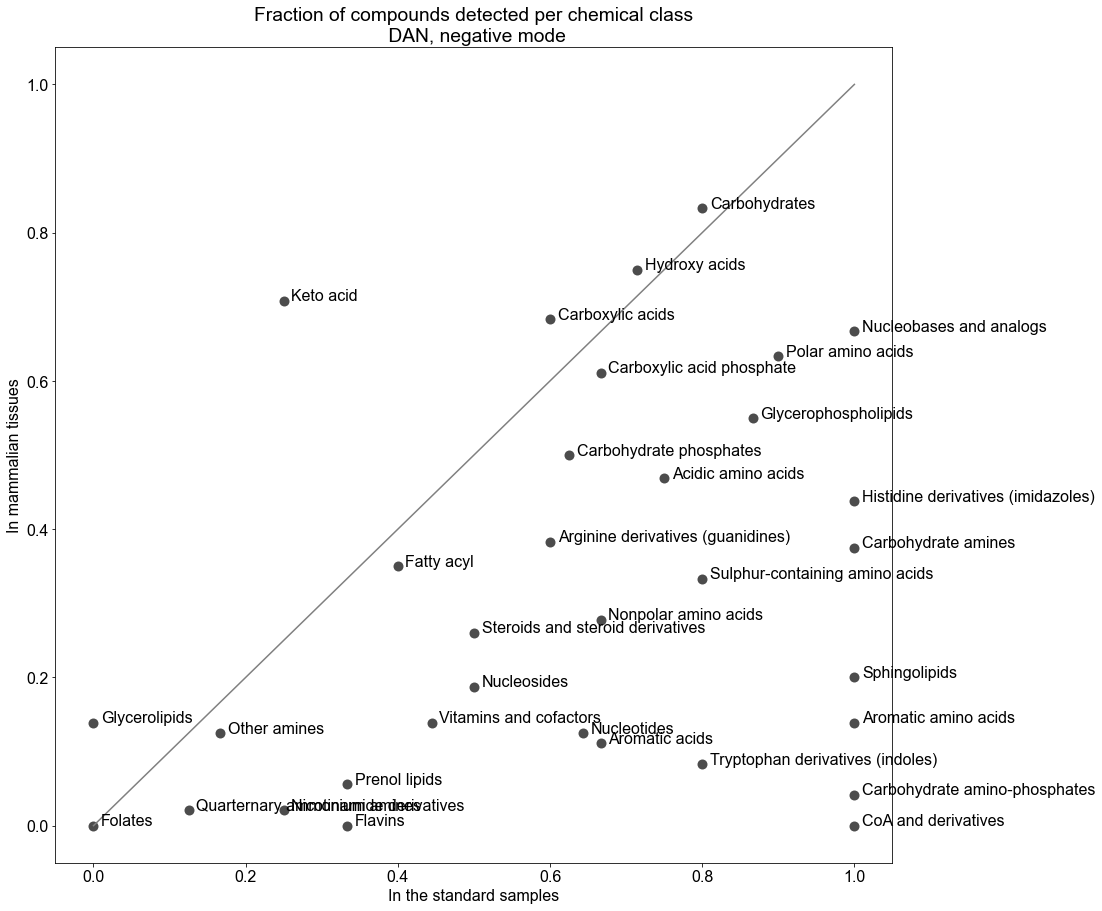

In [19]:
annotate_plot(plot_data, title='Fraction of compounds detected per chemical class\n DAN, negative mode')
plt.savefig(p_out/ f"Detections_in_spots_vs_tissue_DAN_manual_labels_annotated.png")
plt.savefig(p_out/ f"Detections_in_spots_vs_tissue_DAN_manual_labels_annotated.pdf")